In [1]:
# ✅ Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

In [2]:
# ✅ Load the Excel file
file_path = r"C:\Users\Asus\Downloads\Data-Resources\Data & Resources\Data\Prediction_data.xlsx"
sheet_name = 'stg_churn'
data = pd.read_excel(file_path, sheet_name=sheet_name)

# ✅ View initial few rows
print("Raw Data Preview:")
print(data.head())

# ✅ Drop columns that are not useful for prediction (if they exist)
cols_to_drop = ['Customer_ID', 'Churn_Category', 'Churn_Reason']
data = data.drop(columns=[col for col in cols_to_drop if col in data.columns], axis=1)

# ✅ Encode categorical columns using LabelEncoder
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]

label_encoders = {}
for column in columns_to_encode:
    if column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

Raw Data Preview:
  Customer_ID  Gender  Age Married        State  Number_of_Referrals  \
0   19877-DEL    Male   35      No        Delhi                    7   
1   58353-MAH  Female   45     Yes  Maharashtra                   14   
2   25063-WES    Male   51      No  West Bengal                    4   
3   59787-KAR    Male   79      No    Karnataka                    3   
4   28544-TAM  Female   80      No   Tamil Nadu                    3   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                27        NaN           Yes             No  ...   
1                13        NaN           Yes            Yes  ...   
2                35     Deal 5           Yes             No  ...   
3                21     Deal 4           Yes             No  ...   
4                 8        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0      Credit Card           65.6        593.30          0.00   
1      Cre

In [3]:
# ✅ Encode the target column (Customer_Status)
if 'Customer_Status' in data.columns:
    data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

# ✅ Drop rows where target is still NaN (e.g., unmapped or missing values)
data = data.dropna(subset=['Customer_Status'])

In [4]:
# ✅ Split data into features and target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status'].astype(int)

# ✅ Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# ✅ Check for empty training data
if X_train.empty or y_train.empty:
    raise ValueError("Training data is empty. Check preprocessing steps or source data.")


In [6]:
# ✅ Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Confusion Matrix:
[[785  56]
 [134 227]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       841
           1       0.80      0.63      0.70       361

    accuracy                           0.84      1202
   macro avg       0.83      0.78      0.80      1202
weighted avg       0.84      0.84      0.84      1202



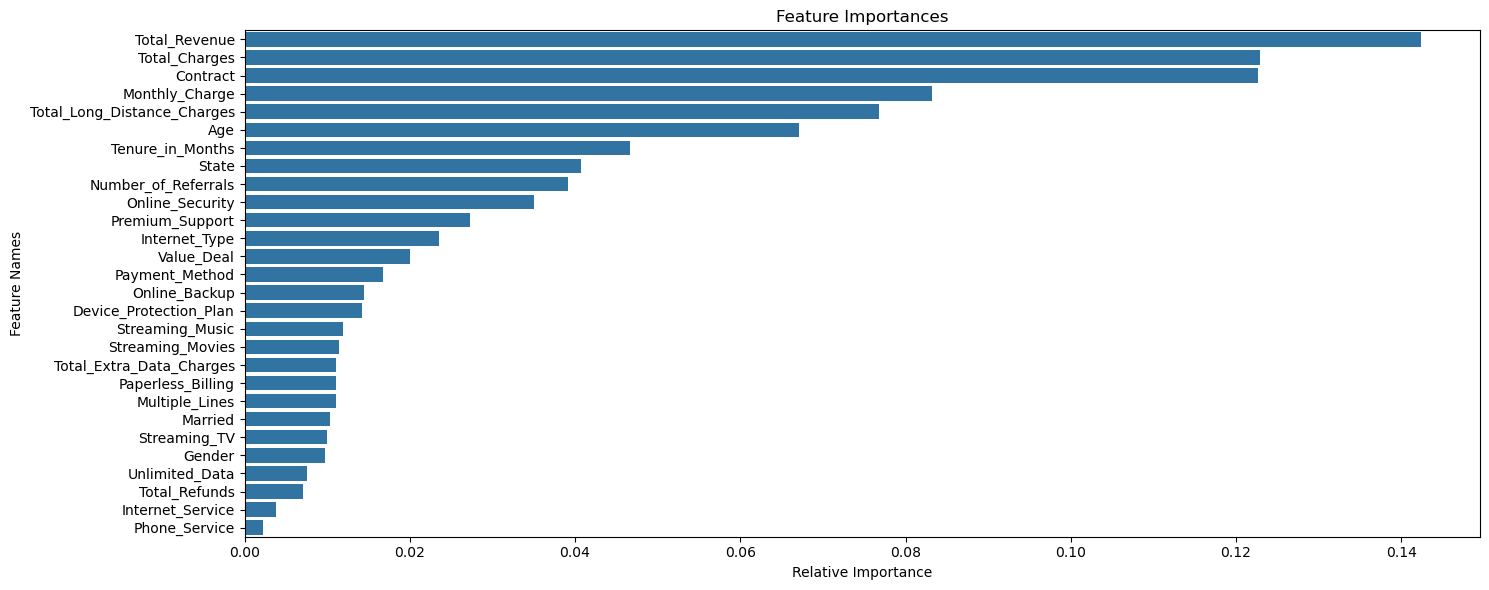

['label_encoders.joblib']

In [7]:
# ✅ Make predictions
y_pred = rf_model.predict(X_test)

# ✅ Evaluate model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ✅ Plot feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.tight_layout()
plt.show()

# ✅ Save model and encoders
joblib.dump(rf_model, 'rf_model.joblib')
joblib.dump(label_encoders, 'label_encoders.joblib')

In [8]:
# Define the path to the new data file
file_path = r"C:\Users\Asus\Downloads\Data-Resources\Data & Resources\Data\Prediction_data.xlsx"
sheet_name = 'prod_churn'

# Load the new data into a DataFrame
new_data = pd.read_excel(file_path, sheet_name=sheet_name)
print("New data preview:")
print(new_data.head())

# Preserve original data and Customer_ID
original_data = new_data.copy()
customer_ids = new_data['Customer_ID'] if 'Customer_ID' in new_data.columns else pd.Series(range(len(new_data)))

# Drop non-predictive columns if they exist
cols_to_drop = ['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason']
new_data = new_data.drop(columns=[col for col in cols_to_drop if col in new_data.columns], axis=1)

# Encode categorical variables using saved label encoders
for column in new_data.select_dtypes(include=['object']).columns:
    if column in label_encoders:
        try:
            new_data[column] = label_encoders[column].transform(new_data[column])
        except ValueError:
            print(f"⚠️ Unknown label in column: {column}. Handle unseen values if needed.")
            new_data[column] = new_data[column].map(lambda x: label_encoders[column].transform([x])[0] if x in label_encoders[column].classes_ else -1)
    else:
        print(f"⚠️ No encoder found for column: {column}")

# Handle missing values before prediction
new_data = new_data.fillna(0)

# Predict churn using the loaded model
new_predictions = rf_model.predict(new_data)

# Add predictions to original data
original_data['Customer_Status_Predicted'] = new_predictions

# Filter for predicted churned customers (label = 1)
churned_customers = original_data[original_data['Customer_Status_Predicted'] == 1]

# Save filtered churn predictions
churned_customers.to_csv(r"C:\Users\Asus\Downloads\Data-Resources\Data & Resources\Data\Predictions.csv", index=False)
print("✅ Predictions saved for churned customers.")


New data preview:
  Customer_ID  Gender  Age Married        State  Number_of_Referrals  \
0   19877-DEL    Male   35      No        Delhi                    7   
1   58353-MAH  Female   45     Yes  Maharashtra                   14   
2   25063-WES    Male   51      No  West Bengal                    4   
3   59787-KAR    Male   79      No    Karnataka                    3   
4   28544-TAM  Female   80      No   Tamil Nadu                    3   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                27        NaN           Yes             No  ...   
1                13        NaN           Yes            Yes  ...   
2                35     Deal 5           Yes             No  ...   
3                21     Deal 4           Yes             No  ...   
4                 8        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0      Credit Card           65.6        593.30          0.00   
1      Cre